In [80]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
from torch.optim.optimizer import Optimizer
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy as np
import random
import torch
import warnings 
warnings.filterwarnings('ignore')
from pytorch_lightning import seed_everything
import os
import gc
gc.collect()

72

# set_seed(42)

In [81]:
def set_seed(seed = int):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random_state = np.random.RandomState(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    seed_everything(seed)
    return random_state
random_state = set_seed(42)

Global seed set to 42


# MADGRAD

In [82]:
import math
from typing import TYPE_CHECKING, Any, Callable, Optional

if TYPE_CHECKING:
    from torch.optim.optimizer import _params_t
else:
    _params_t = Any

class MADGRAD(Optimizer):

    def __init__(
        self, params: _params_t, lr: float = 1e-2, momentum: float = 0.9, weight_decay: float = 0, eps: float = 1e-6,
    ):
        if momentum < 0 or momentum >= 1:
            raise ValueError(f"Momentum {momentum} must be in the range [0,1]")
        if lr <= 0:
            raise ValueError(f"Learning rate {lr} must be positive")
        if weight_decay < 0:
            raise ValueError(f"Weight decay {weight_decay} must be non-negative")
        if eps < 0:
            raise ValueError(f"Eps must be non-negative")

        defaults = dict(lr=lr, eps=eps, momentum=momentum, weight_decay=weight_decay)
        super().__init__(params, defaults)

    @property
    def supports_memory_efficient_fp16(self) -> bool:
        return False

    @property
    def supports_flat_params(self) -> bool:
        return True

    def step(self, closure: Optional[Callable[[], float]] = None) -> Optional[float]:

        loss = None
        if closure is not None:
            loss = closure()

        if 'k' not in self.state:
            self.state['k'] = torch.tensor([0], dtype=torch.long)
        k = self.state['k'].item()

        for group in self.param_groups:
            eps = group["eps"]
            lr = group["lr"] + eps
            decay = group["weight_decay"]
            momentum = group["momentum"]

            ck = 1 - momentum
            lamb = lr * math.pow(k + 1, 0.5)

            for p in group["params"]:
                if p.grad is None:
                    continue
                grad = p.grad.data
                state = self.state[p]

                if "grad_sum_sq" not in state:
                    state["grad_sum_sq"] = torch.zeros_like(p.data).detach()
                    state["s"] = torch.zeros_like(p.data).detach()
                    if momentum != 0:
                        state["x0"] = torch.clone(p.data).detach()

                if momentum != 0.0 and grad.is_sparse:
                    raise RuntimeError("momentum != 0 is not compatible with sparse gradients")

                grad_sum_sq = state["grad_sum_sq"]
                s = state["s"]

                # Apply weight decay
                if decay != 0:
                    if grad.is_sparse:
                        raise RuntimeError("weight_decay option is not compatible with sparse gradients")

                    grad.add_(p.data, alpha=decay)

                if grad.is_sparse:
                    grad = grad.coalesce()
                    grad_val = grad._values()

                    p_masked = p.sparse_mask(grad)
                    grad_sum_sq_masked = grad_sum_sq.sparse_mask(grad)
                    s_masked = s.sparse_mask(grad)

                    # Compute x_0 from other known quantities
                    rms_masked_vals = grad_sum_sq_masked._values().pow(1 / 3).add_(eps)
                    x0_masked_vals = p_masked._values().addcdiv(s_masked._values(), rms_masked_vals, value=1)

                    # Dense + sparse op
                    grad_sq = grad * grad
                    grad_sum_sq.add_(grad_sq, alpha=lamb)
                    grad_sum_sq_masked.add_(grad_sq, alpha=lamb)

                    rms_masked_vals = grad_sum_sq_masked._values().pow_(1 / 3).add_(eps)

                    s.add_(grad, alpha=lamb)
                    s_masked._values().add_(grad_val, alpha=lamb)

                    # update masked copy of p
                    p_kp1_masked_vals = x0_masked_vals.addcdiv(s_masked._values(), rms_masked_vals, value=-1)
                    # Copy updated masked p to dense p using an add operation
                    p_masked._values().add_(p_kp1_masked_vals, alpha=-1)
                    p.data.add_(p_masked, alpha=-1)
                else:
                    if momentum == 0:
                        # Compute x_0 from other known quantities
                        rms = grad_sum_sq.pow(1 / 3).add_(eps)
                        x0 = p.data.addcdiv(s, rms, value=1)
                    else:
                        x0 = state["x0"]

                    # Accumulate second moments
                    grad_sum_sq.addcmul_(grad, grad, value=lamb)
                    rms = grad_sum_sq.pow(1 / 3).add_(eps)

                    # Update s
                    s.data.add_(grad, alpha=lamb)

                    # Step
                    if momentum == 0:
                        p.data.copy_(x0.addcdiv(s, rms, value=-1))
                    else:
                        z = x0.addcdiv(s, rms, value=-1)

                        # p is a moving average of z
                        p.data.mul_(1 - ck).add_(z, alpha=ck)


        self.state['k'] += 1
        return loss

# LOAD DATA

In [83]:
df = pd.read_csv('46A47A78LCBK.csv',index_col=0)
df

,46A,47A,78,LCBK
3,1 SIGNED COMMERCIAL INVOICE IN 3 ORIGINALS AND...,1 ALL DOCUMENTS MUST BE IN ENGLISH2 ALL DOCUME...,UPON RECEIPT OF CREDIT COMPLIANT DOCUMENTS AT ...,ICICI BANK LTDSHALIMAR TOWER 3154 MGMARGHAZRAT...
4,1 SIGNED COMMERCIAL INVOICE IN ORIGINAL AND 4 ...,A ALL DOCUMENTS AND DRAFTS IF CALLED FOR UNDER...,IN REIMBURSEMENT OF NEGOTIATION MADE BY YOUIN ...,NATIONAL COMMERCIAL BANK THEHEAD OFFICE
5,1SIGNED COMMERCIAL INVOICE IN 03 ORIGINALS AND...,ALL DOCUMENTS MUST MADE IN ENGLISHALL DOCUMENT...,UPON RECEIPT OF ALL DOCUMENTS SENT TO USVIETNA...,VIET NAM BANK FOR AGRICULTURE AND RURAL DEVELO...
7,SIGNED COMMERCIAL INVOICE IN TRIPLICATE INDICA...,ALL DRAFTS DRAWN HEREUNDER MUST BE MARKED DRAW...,ALL DOCUMENTS INCLUDING BENEFICIARYS DRAFTS MU...,THE MIZUHO BANKLTDHEAD OFFICE
9,SIGNED COMMERCIAL INVOICE IN TRIPLICATE INDICA...,ALL DRAFTS DRAWN HEREUNDER MUST BE MARKED DRAW...,ALL DOCUMENTS INCLUDING BENEFICIARYS DRAFTS MU...,THE MIZUHO BANKLTDHEAD OFFICE
...,...,...,...,...
8403,1SIGNED COMMERCIAL INVOICE IN 3 ORIGINALS INDI...,1 ALL DOCUMENTS MUST BE DATED SIGNED AND ISSUE...,THE AMOUNT OF EACH DRAWING UNDER THIS CREDIT M...,AGRICULTURAL BANK OF CHINA LTD
8413,COMMERCIAL INVOICE IN 3 ORIGINALx000D 23 SET O...,TTREIMBURSEMENT PROHIBITEDx000D INSURANCE IS ...,ALL DOCS TO BE SENT DIRECTLY TO US 3-10-19 MIN...,SUMITOMO MITSUI BANKING CORPORATION JAPAN
8414,SIGNED AND STAMPED COMMERCIAL INVOICE IN 3 ORI...,KINDLY ASSIST US TO RELAY THIS CREDIT TO CITIT...,TO NEGOTIATING BANK ONLY PLEASE FORWARD ALL D...,CTBC BANK COLTD
8415,SIGNED AND STAMPED COMMERCIAL INVOICE IN 3 ORI...,KINDLY ASSIST US TO RELAY THIS CREDIT TO CITIT...,TO NEGOTIATING BANK ONLY PLEASE FORWARD ALL D...,CTBC BANK COLTD


In [84]:
from sklearn.model_selection import train_test_split
df['tab'] = ' '
df['string_X_train'] = df['46A']+df['tab']+df['47A']+df['tab']+df['78']
df = df[['string_X_train','LCBK']]
df = df.rename(columns={'LCBK':'Y_label'})
df['string_X_train'] = [str(i) for i in df['string_X_train']]
df['Y_label'] = [str(i) for i in df['Y_label']]
df.head()

,string_X_train,Y_label
3,1 SIGNED COMMERCIAL INVOICE IN 3 ORIGINALS AND...,ICICI BANK LTDSHALIMAR TOWER 3154 MGMARGHAZRAT...
4,1 SIGNED COMMERCIAL INVOICE IN ORIGINAL AND 4 ...,NATIONAL COMMERCIAL BANK THEHEAD OFFICE
5,1SIGNED COMMERCIAL INVOICE IN 03 ORIGINALS AND...,VIET NAM BANK FOR AGRICULTURE AND RURAL DEVELO...
7,SIGNED COMMERCIAL INVOICE IN TRIPLICATE INDICA...,THE MIZUHO BANKLTDHEAD OFFICE
9,SIGNED COMMERCIAL INVOICE IN TRIPLICATE INDICA...,THE MIZUHO BANKLTDHEAD OFFICE


In [85]:
df = df.dropna(subset=['string_X_train','Y_label'],axis=0).reset_index(drop=True)
print(df.shape)
keep_lst = []
for i in range(len(df)):
    if df.iloc[i]['Y_label'] in df.iloc[i]['string_X_train']:
        keep_lst.append(i)
df = df.iloc[keep_lst]
print(df.shape)

(3643, 2)
(1415, 2)


In [86]:
def str2index(context,string):
    ys = context.find(string)
    ye = ys + len(string)
    return ys,ye

ys_lst = []
ye_lst = []
for i in range(len(df)):
    context= df['string_X_train'].values[i]
    string = df['Y_label'].values[i]
    ys,ye = str2index(context,string)
    ys_lst.append(ys)
    ye_lst.append(ye)
df['string_Y_1'] = ys_lst
df['string_Y_2'] = ye_lst
df.head()

,string_X_train,Y_label,string_Y_1,string_Y_2
8,SIGNED COMMERCIAL INVOICE IN 3 ORIGINALS INDIC...,CTBC BANK CO LTD,1860,1876
9,SIGNED COMMERCIAL INVOICE IN 2 ORIGINALINDICAT...,CTBC BANK CO LTD,4924,4940
10,SIGNED COMMERCIAL INVOICE IN 2 ORIGINALINDICAT...,CTBC BANK CO LTD,4924,4940
13,1SIGNED COMMERCIAL INVOICE IN DUPLICATE SHOWIN...,CHANG HWA COMMERCIAL BANK LTD,5345,5374
19,1FULL SET OF ORIGINALS AND 2 NON-NEGOTIABLE CO...,STANDARD CHARTERED BANK,1596,1619


In [87]:
for i in range(10):
    print(df['string_X_train'].values[i][df['string_Y_1'].values[i]:df['string_Y_2'].values[i]],df['Y_label'].values[i])

CTBC BANK CO LTD CTBC BANK CO LTD
CTBC BANK CO LTD CTBC BANK CO LTD
CTBC BANK CO LTD CTBC BANK CO LTD
CHANG HWA COMMERCIAL BANK LTD CHANG HWA COMMERCIAL BANK LTD
STANDARD CHARTERED BANK STANDARD CHARTERED BANK
STANDARD CHARTERED BANK STANDARD CHARTERED BANK
STANDARD CHARTERED BANK STANDARD CHARTERED BANK
AXIS BANK LIMITED AXIS BANK LIMITED
AXIS BANK LIMITED AXIS BANK LIMITED
AXIS BANK LIMITED AXIS BANK LIMITED


In [88]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Model and Tokenizer Initialization

In [89]:
from transformers import DistilBertTokenizerFast
from transformers import DistilBertForQuestionAnswering

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
model = DistilBertForQuestionAnswering.from_pretrained("distilbert-base-uncased")
gc.collect()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForQuestionAnswering: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this mode

258

# Data preprocessing

In [90]:
def preprocessing(df):
    contexts = df['string_X_train'].values.tolist()
    questions = [ 'What is the bank name?' for i in range(len(df))]
    answers = []
    for idx in df.index:
        answers.append({
            'text':df.loc[idx,'Y_label'],
            'answer_start':df.loc[idx,'string_Y_1'],
            'answer_end':df.loc[idx,'string_Y_2'],
            })
    return contexts ,questions ,answers

train_contexts ,train_questions ,train_answers = preprocessing(train_df)
val_contexts ,val_questions ,val_answers = preprocessing(val_df)
gc.collect()

0

# tokenize our context/question pairs

In [91]:
train_encodings = tokenizer(train_contexts, train_questions, truncation=True, padding=True)
val_encodings = tokenizer(val_contexts, val_questions, truncation=True, padding=True)
gc.collect()

0

# add_token_positions

In [92]:
def add_token_positions(encodings, answers):
    start_positions = []
    end_positions = []
    for i in range(len(answers)):
        start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
        end_positions.append(encodings.char_to_token(i, answers[i]['answer_end'] - 1))

        # if start position is None, the answer passage has been truncated
        if start_positions[-1] is None:
            start_positions[-1] = tokenizer.model_max_length
        if end_positions[-1] is None:
            end_positions[-1] = tokenizer.model_max_length

    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

add_token_positions(train_encodings, train_answers)
add_token_positions(val_encodings, val_answers)
gc.collect()

21

# data is ready put it in a PyTorch dataset

In [93]:
import torch

class SquadDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

train_dataset = SquadDataset(train_encodings)
val_dataset = SquadDataset(val_encodings)
gc.collect()

21

# train loop

In [94]:
from torch.utils.data import DataLoader

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
model.to(device)
model.train()
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle=True ,num_workers=4)
val_loader = DataLoader(val_dataset, batch_size = 32, shuffle=True ,num_workers=4)
optimizer = MADGRAD(model.parameters(),lr=5e-5)
gc.collect()

def train_step(model,batch,optimizer):
    model = model.to(device)
    model.train()
    # forward
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    start_positions = batch['start_positions'].to(device)
    end_positions = batch['end_positions'].to(device)
    outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
    loss = outputs[0]
    
    # update model
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    gc.collect()
    return loss.item()

def val_step(model,batch,optimizer):
    model = model.to(device)
    model.eval()
    # forward
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    start_positions = batch['start_positions'].to(device)
    end_positions = batch['end_positions'].to(device)
    outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
    loss = outputs[0]
    
    gc.collect()
    return loss.item()

def train_loop(model,train_loader,val_loader,optimizer,max_epochs=5,patience=3):
    history = {'train_loss':[],'val_loss':[]}
    best_loss = np.inf
    best_model = None
    not_improve_count = 0
    for epoch in tqdm(range(max_epochs)):    
        # reset this epoch loss equal to zero
        epoch_train_loss = 0.0
        epoch_val_loss = 0.0

        # train one epoch and get train_loss
        for i,batch in enumerate(tqdm(train_loader)):
            epoch_train_loss += train_step(model,batch,optimizer)

        # val one epoch and get val_loss
        for j,batch in enumerate(tqdm(val_loader)):
            epoch_val_loss += val_step(model,batch,optimizer)

        # record loss history
        history['train_loss'].append(epoch_train_loss/i)
        history['val_loss'].append(epoch_val_loss/j)

        # print this epoch's infomation
        print(f'epoch:{epoch} train_loss:{epoch_train_loss/i} val_loss:{epoch_val_loss/j}')

        # save best_model (if current val_loss <= best_loss)
        if history['val_loss'][-1] <= best_loss: 
            best_model = deepcopy(model.eval())
            best_loss = history['val_loss'][-1]
            print(f'save best_model now_val_best_loss is:{best_loss}')

        if history['val_loss'][-1] > best_loss:
            not_improve_count += 1
            print(f'not_improve_count:{not_improve_count}')
            if not_improve_count > patience:
                print('early_stoping')
                break

    # GET best_model.eval()
    model = best_model.eval()
    return model,history

cuda


In [95]:
model,history = train_loop(model,train_loader,val_loader,optimizer,max_epochs=5,patience=3)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/9 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/36 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/9 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/36 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/9 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/36 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/9 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/36 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/9 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

# loss curve

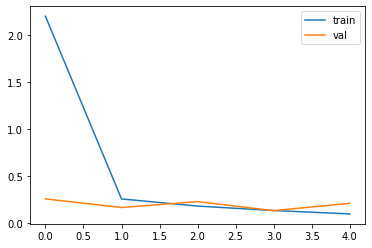

In [96]:
plt.plot(history['train_loss'],label='train')
plt.plot(history['val_loss'],label='val')
plt.legend()
plt.show()

# question-answering pipeline

In [117]:
from transformers import pipeline
nlp = pipeline('question-answering', model=model.to('cpu'), tokenizer=tokenizer)

# test

In [118]:
def test_model(df):
    table = pd.DataFrame()
    for i in tqdm(df.index):
        sample = df.loc[[i]]
        string_X_train = sample['string_X_train'].values[0]
        string_Y_1 = sample['string_Y_1'].values[0]
        string_Y_2 = sample['string_Y_2'].values[0]
        QA_input = {
            'question': 'What is the product name?',
            'context': string_X_train
        }
        res = nlp(QA_input)
        predict = QA_input['context'][res['start']:res['end']]
        row = pd.DataFrame({
            'label':string_X_train[string_Y_1:string_Y_2],
            'predict:':predict},index=[i])
        if string_X_train[string_Y_1:string_Y_2] == predict:
            row['是否全對'] = 'Yes'
        else:
            row['是否全對'] = 'No'
        table = table.append(row)
        i += 1
    return table

# 最後讓我們來看看模型在驗證集上的表現

In [126]:
all_res = test_model(val_df.sample(99))
all_res

  0%|          | 0/99 [00:00<?, ?it/s]

,label,predict:,是否全對
2240,AGRICULTURAL BANK OF CHINA,AGRICULTURAL BANK OF CHINA,Yes
2639,BDO UNIBANK INC,BDO UNIBANK INC,Yes
1872,MIZUHO BANK LTD,MIZUHO BANK LTDx000D,No
2483,CTBC BANK CO LTD,BANKERx000DCTBC BANK CO LTD,No
80,CTBC BANK CO LTD,CTBC BANK CO LTD,Yes
...,...,...,...
3063,BANK OF CHINA LTD,ADDRESSBANK OF CHINA LTDXIAMEN,No
2967,AGRICULTURAL BANK OF CHINA,THEx000DAGRICULTURAL BANK OF CHINA LTD,No
2132,MUFG BANK LTD,MUFG BANK LTD,Yes
2661,TAISHIN INTERNATIONAL BANK,TAISHIN INTERNATIONAL BANKx000D,No


# claculate acc and jaccard

In [127]:
def get_jaccard_sim(str1, str2): 
    a = set(str1.split()) 
    b = set(str2.split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

display(all_res['是否全對'].value_counts())
acc = all_res['是否全對'].value_counts()['Yes']/len(all_res)
print('acc:',acc)
jaccard_avg_score = np.mean([ get_jaccard_sim(all_res.label.loc[i],all_res['predict:'].loc[i]) for i in all_res.index])
print('jaccard_avg_score:',jaccard_avg_score)

No     63
Yes    36
Name: 是否全對, dtype: int64

acc: 0.36363636363636365
jaccard_avg_score: 0.6571341116795661


# 放水acc

In [128]:
def get_acc(df,t=0.75):
    correct = []
    correct_label = []
    for i in df.index:
        jac = get_jaccard_sim(df.loc[i,'label'],df.loc[i,'predict:'])
        if jac >= t:
            correct.append('yes')
        else:
            correct.append('no')
    result = pd.Series(correct)
    return result.value_counts()['yes']/len(result)

In [129]:
get_acc(all_res)

0.40404040404040403